# 对用户进行聚类

数据来源于Kaggle竞赛：Event Recommendation Engine Challenge，根据
events they’ve responded to in the past
user demographic information
what events they’ve seen and clicked on in our app
用户对某个事件是否感兴趣

竞赛官网：
https://www.kaggle.com/c/event-recommendation-engine-challenge/data

由于用户众多（3w+），可以对用户进行聚类
事件描述信息在users.csv文件：共110维特征
user_id
locale：地区，语言
birthyear：出身年
gender：性别
joinedAt：用户加入APP的时间，ISO-8601 UTC time
location：地点
timezone：时区

作业要求：
根据用户的属性进行聚类（KMeans聚类）
尝试K=20， 40， 80，并计算各自CH_scores。

提示：由于样本数目较多，建议使用MiniBatchKMeans。

In [2]:
## 导入工具包
import pandas as pd
import numpy as np

In [3]:
#读取数据
import pandas as pd
df = pd.read_csv("./data/users.csv")
df.head()

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0


In [4]:
n_records = df.shape[0]
n_records

38209

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 7 columns):
user_id      38209 non-null int64
locale       38209 non-null object
birthyear    38209 non-null object
gender       38100 non-null object
joinedAt     38152 non-null object
location     32745 non-null object
timezone     37773 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.0+ MB


In [6]:
#并统计有多少不同的users（n_users）
def get_uniqueUsers():
    uniqueUsers = set()
    
    for i in range(n_records):
        uniqueUsers.add(df.loc[i,'user_id'])
    
    n_events = len(uniqueUsers)
    return n_events

n_users = get_uniqueUsers()

In [7]:
n_users

38209

记录的数目等于用户的数目，Bingo

In [8]:
#user_id不作为聚类属性
df = df.drop(["user_id"], axis=1)
        
#location有缺失值，粗暴抛弃
#也可以将缺失值作为另外一类：others
df = df.drop(["location"], axis=1)
df.head()

,locale,birthyear,gender,joinedAt,timezone
0,id_ID,1993,male,2012-10-02T06:40:55.524Z,480.0
1,id_ID,1992,male,2012-09-29T18:03:12.111Z,420.0
2,en_US,1975,male,2012-10-06T03:14:07.149Z,-240.0
3,en_US,1991,female,2012-11-04T08:59:43.783Z,210.0
4,id_ID,1995,female,2012-09-10T16:06:53.132Z,420.0


In [9]:
#特征编码
import datetime
import hashlib
import locale

from collections import defaultdict
from sklearn.preprocessing import normalize

class FeatureEng:
    def __init__(self):
         # 载入 locales
        self.localeIdMap = defaultdict(int)
        for i, l in enumerate(locale.locale_alias.keys()):
          self.localeIdMap[l] = i + 1
        
        # 载入 gender id 字典
        ##缺失补0
        self.genderIdMap = defaultdict(int, {'NaN': 0, "male":1, "female":2})

  
    def getLocaleId(self, locstr):
        return self.localeIdMap[locstr.lower()]

    def getGenderId(self, genderStr):
        return self.genderIdMap[genderStr]

    def getJoinedYearMonth(self, dateString):
        try:
            dttm = datetime.datetime.strptime(dateString, "%Y-%m-%dT%H:%M:%S.%fZ")
            #return "".join([str(dttm.year), str(dttm.month)])
            return (dttm.year-2010)*12 + dttm.month
        except:  #缺失补0
          return 0

    def getBirthYearInt(self, birthYear):
        #缺失补0
        try:
          return 0 if birthYear == "None" else int(birthYear)
        except:
          return 0

    def getTimezoneInt(self, timezone):
        try:
          return int(timezone)
        except:  #缺失值处理
          return 0

In [10]:
FE = FeatureEng()

cols = ['LocaleId', 'BirthYearInt', 'GenderId', 'JoinedYearMonth', 'TimezoneInt']
n_cols = len(cols)
userMatrix = np.zeros((df.shape[0],n_cols), dtype=np.int)

for i in range(df.shape[0]): 
    userMatrix[i, 0] = FE.getLocaleId(df.loc[i,'locale'])
    userMatrix[i, 1] = FE.getBirthYearInt(df.loc[i,'birthyear'])
    userMatrix[i, 2] = FE.getGenderId(df.loc[i,'gender'])
    userMatrix[i, 3] = FE.getJoinedYearMonth(df.loc[i,'joinedAt'])
    #userMatrix[i, 4] = FE.getCountryId(df[''])
    userMatrix[i, 4] = FE.getTimezoneInt(df.loc[i,'timezone'])

# 归一化用户矩阵
userMatrix = normalize(userMatrix, norm="l1", axis=0, copy=False)

df_FE = pd.DataFrame(data=userMatrix, columns=cols)  
#mmwrite("US_userMatrix", userMatrix)

In [11]:
df_FE.head()

,LocaleId,BirthYearInt,GenderId,JoinedYearMonth,TimezoneInt
0,0.000036,0.000027,0.000019,0.000026,0.000036
1,0.000036,0.000027,0.000019,0.000026,0.000031
2,0.000020,0.000027,0.000019,0.000026,-0.000018
3,0.000020,0.000027,0.000038,0.000027,0.000016
4,0.000036,0.000027,0.000038,0.000026,0.000031


In [12]:
#缺失值填补
#BirthYearInt
#JoinedYearMonth     38152 non-null object
#TimezoneInt     37773 non-null float64
#mean_BirthYearInt = np.mean(df_FE["BirthYearInt"]) 
#df_FE.loc[df_FE["BirthYearInt"] == 0, "BirthYearInt"] = mean_BirthYearInt

In [30]:
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

# 一个参数点（聚类数据为K）的模型，在校验集上评价聚类算法性能
def K_cluster_analysis(K, df_FE):
    
    print("K-means begin with clusters: {}".format(K));
    
    #K-means,在训练集上训练
    mb_kmeans = MiniBatchKMeans(n_clusters = K)
    mb_kmeans.fit(df_FE)
    
    # K值的评估标准
    #常见的方法有轮廓系数Silhouette Coefficient和Calinski-Harabasz Index
    #这两个分数值越大则聚类效果越好
    #CH_score = metrics.calinski_harabaz_score(X_train,mb_kmeans.predict(X_train))
    CH_score = metrics.silhouette_score(df_FE,mb_kmeans.predict(df_FE))
  
    print("CH_score: {}".format(CH_score))

    return CH_score

In [31]:
Ks = [10,20,30, 40,50 ,80]
CH_scores = []
for K in Ks:
    ch= K_cluster_analysis(K, df_FE)
    CH_scores.append(ch)

K-means begin with clusters: 10
CH_score: 0.5757476613904771
K-means begin with clusters: 20
CH_score: 0.6840402086809495
K-means begin with clusters: 30
CH_score: 0.7018981454479846
K-means begin with clusters: 40
CH_score: 0.7187351990507763
K-means begin with clusters: 50
CH_score: 0.6988822126670933
K-means begin with clusters: 80
CH_score: 0.5394617960431316


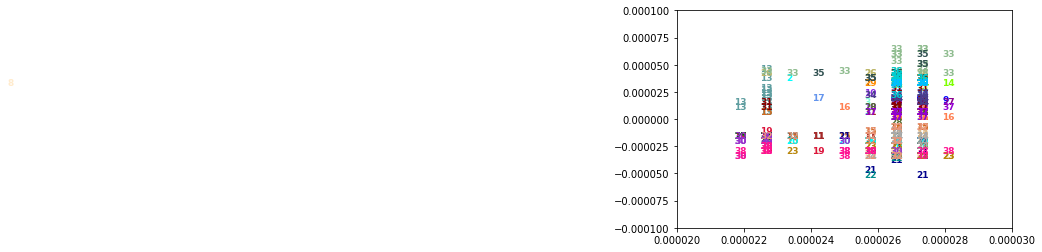

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline


n_clusters = 40
mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters)
mb_kmeans.fit(df_FE)
y_train_pred = mb_kmeans.labels_
df_FE['cluster_40'] = y_train_pred

#
#显示聚类结果
#画出聚类结果，每一类用一种颜色
colors = ['#F0F8FF','#FAEBD7','#00FFFF','#7FFFD4','#F0FFFF','#F5F5DC','#FFE4C4','#000000','#FFEBCD','#0000FF'
          ,'#8A2BE2','#A52A2A','#DEB887','#5F9EA0','#7FFF00','#D2691E','#FF7F50','#6495ED','#FFF8DC','#DC143C'
          ,'#00FFFF','#00008B','#008B8B','#B8860B','#A9A9A9','#006400','#BDB76B','#8B008B','#556B2F','#FF8C00',
          '#9932CC','#8B0000','#E9967A','#8FBC8F','#483D8B','#2F4F4F','#00CED1','#9400D3','#FF1493','#00BFFF']

cents = mb_kmeans.cluster_centers_#质心

for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x1 = userMatrix[index,3]
    x2 = userMatrix[index,4]
    y_i = y_train_pred[index]
    for j in range(len(x1)):
        if j < 20:  #每类打印20个
            plt.text(x1[j],x2[j],str(int(y_i[j])),color=colors[i],\
                fontdict={'weight': 'bold', 'size': 9})
    #plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],linewidths=12)

plt.axis([0.00002,0.00003,-0.0001,0.0001])
plt.show()

In [74]:
#保存预测结果
df_FE.to_csv('users_FE.csv')

In [75]:
df_FE.head()

,LocaleId,BirthYearInt,GenderId,JoinedYearMonth,TimezoneInt,cluster_20,cluster_40
0,0.000036,0.000027,0.000019,0.000026,0.000036,0.627504,32
1,0.000036,0.000027,0.000019,0.000026,0.000031,0.627504,0
2,0.000020,0.000027,0.000019,0.000026,-0.000018,0.627504,6
3,0.000020,0.000027,0.000038,0.000027,0.000016,0.627504,2
4,0.000036,0.000027,0.000038,0.000026,0.000031,0.627504,27
